In [1]:
import os
import numpy as np
import pandas as pd
import pandas_datareader as web 
import datetime as dt
from dateutil.relativedelta import relativedelta
from duneanalytics import DuneAnalytics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../'
helper_dir = os.path.join(base_dir, 'helper')
png_dir = os.path.join(base_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/access_dune.py

## Download daily closes from yahoo

In [4]:
start = dt.datetime(2021, 1, 1)  # first row of downloaded data will be 2018-01-31
end = dt.datetime.now() - relativedelta(days=1) # exclude today since it may not be a full day

In [5]:
tickers = ['BTC-USD', 'ETH-USD', 'AVAX-USD', 'SOL-USD', 'LUNA1-USD', 'ATOM-USD', 'NEAR-USD', 'DOGE-USD', 'SHIB-USD', 'LINK-USD', 
           'UNI1-USD', 'AAVE-USD', 'MKR-USD', 'LRC-USD', 'SNX-USD', 'COMP1-USD', 'YFI-USD', 'SUSHI-USD', 'KNC-USD', 'REN-USD',
           'BAL-USD', 'BADGER-USD', 'RGT-USD', 'CRV-USD', 'CVX-USD', 'FXS-USD', 'ALCX-USD', 'GMX-USD', 'DPX-USD', 'PREMIA-USD']

In [6]:
prices = web.get_data_yahoo(tickers, start, end)['Close']
prices.tail()

Symbols,BTC-USD,ETH-USD,AVAX-USD,SOL-USD,LUNA1-USD,ATOM-USD,NEAR-USD,...,CRV-USD,CVX-USD,FXS-USD,ALCX-USD,GMX-USD,DPX-USD,PREMIA-USD
Date,,,,,,,,,,,,,,,
2022-09-12,"22,370.4492","1,713.7653",21.3482,37.4242,0.0003,15.5074,5.0844,...,1.1419,5.3371,6.2998,23.0641,0.0001,434.7926,1.4682
2022-09-13,"20,296.7070","1,580.7880",19.0683,33.4308,0.0004,14.0564,4.4646,...,1.0848,5.0246,5.5983,21.6419,0.0001,391.1028,1.2856
2022-09-14,"20,241.0898","1,634.7550",19.1208,34.0916,0.0003,13.9910,4.5075,...,1.0707,4.9568,5.5655,21.6499,0.0001,362.3961,1.2669
2022-09-15,"19,701.2109","1,471.6935",18.1861,33.0477,0.0003,14.9067,4.1766,...,1.0510,4.8435,5.3935,21.2828,0.0001,311.9143,1.1025
2022-09-16,"19,772.5840","1,432.4478",18.0566,32.2089,0.0003,16.5943,4.2031,...,1.0548,4.7735,5.1554,21.0954,0.0001,274.0275,1.1023


## Query daily median prices from Dune

In [7]:
# query daily prices for GLP and TriCrypto
glp_arbi_prices = dune.query_result(dune.query_result_id(query_id=1069389))
tricrypto_prices = dune.query_result(dune.query_result_id(query_id=1145739))
df_glp_prices = (extract_frame_from_dune_data(glp_arbi_prices, 'date')
    .rename({'price':'GLP'}, axis=1)) # today's price is removed
df_tri_prices = (extract_frame_from_dune_data(tricrypto_prices, 'date')
    .rename({'price':'TriCrypto'}, axis=1)) # today's price is removed 

In [8]:
# TriCrypto price became available on 2021-06-09 and GLP on 2021-08-31.
df_bench = df_tri_prices.join(df_glp_prices).dropna()
print(df_bench.head(), '\n\n')
print(df_bench.tail(), '\n\n')

            TriCrypto    GLP
date                        
2021-08-31 1,642.3732 1.1783
2021-09-01 1,657.8282 1.2595
2021-09-02 1,722.3775 1.2789
2021-09-03 1,753.0746 1.3158
2021-09-04 1,750.1683 1.3084 


            TriCrypto    GLP
date                        
2022-09-12 1,041.3420 0.9487
2022-09-13 1,005.0403 0.9281
2022-09-14   974.3594 0.9206
2022-09-15   951.4613 0.9209
2022-09-16   940.7752 0.9056 




## Calculate daily returns

In [9]:
daily_rets = prices.pct_change().dropna()
daily_rets.tail()

Symbols,BTC-USD,ETH-USD,AVAX-USD,SOL-USD,LUNA1-USD,ATOM-USD,NEAR-USD,...,CRV-USD,CVX-USD,FXS-USD,ALCX-USD,GMX-USD,DPX-USD,PREMIA-USD
Date,,,,,,,,,,,,,,,
2022-09-12,0.0276,-0.0273,0.0334,0.0703,-0.2888,-0.0111,0.0390,...,-0.0344,-0.0404,-0.0376,-0.0182,0.0000,-0.0636,-0.0533
2022-09-13,-0.0927,-0.0776,-0.1068,-0.1067,0.1946,-0.0936,-0.1219,...,-0.0501,-0.0586,-0.1113,-0.0617,0.4286,-0.1005,-0.1243
2022-09-14,-0.0027,0.0341,0.0028,0.0198,-0.1573,-0.0046,0.0096,...,-0.0129,-0.0135,-0.0059,0.0004,0.0000,-0.0734,-0.0145
2022-09-15,-0.0267,-0.0997,-0.0489,-0.0306,-0.1433,0.0654,-0.0734,...,-0.0184,-0.0228,-0.0309,-0.0170,-0.3000,-0.1393,-0.1298
2022-09-16,0.0036,-0.0267,-0.0071,-0.0254,0.2101,0.1132,0.0064,...,0.0036,-0.0145,-0.0441,-0.0088,0.0000,-0.1215,-0.0001


In [10]:
daily_rets_bench = df_bench.pct_change().dropna()
daily_rets_bench.tail()

,TriCrypto,GLP
date,,
2022-09-12,0.0090,0.0013
2022-09-13,-0.0349,-0.0217
2022-09-14,-0.0305,-0.0081
2022-09-15,-0.0235,0.0004
2022-09-16,-0.0112,-0.0166


In [11]:
# make sure the basket of tokens and benchmark tokens have the same start and end dates so we can compare them later
date0 = max(daily_rets.index.min(), daily_rets_bench.index.min())
date1 = min(daily_rets.index.max(), daily_rets_bench.index.max())
daily_rets = daily_rets.loc[date0:date1, :]
daily_rets_bench = daily_rets_bench.loc[date0:date1, :]

## Backtest Stragety: long past winners and short past losers

In [12]:
ndays = 4  # input

In [13]:
# calculate returns over the past n days
past_nday_rets = (daily_rets+1).rolling(ndays).apply(np.prod)-1
past_nday_rets

Symbols,BTC-USD,ETH-USD,AVAX-USD,SOL-USD,LUNA1-USD,ATOM-USD,NEAR-USD,...,CRV-USD,CVX-USD,FXS-USD,ALCX-USD,GMX-USD,DPX-USD,PREMIA-USD
Date,,,,,,,,,,,,,,,
2021-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-04,0.0589,0.1322,0.1939,0.2823,-0.0049,0.0683,0.1490,...,0.0182,0.4575,-0.0612,0.1684,-0.2081,0.1474,0.1472
2021-09-05,0.0595,0.0306,0.1490,0.2795,0.0892,0.0159,0.1175,...,0.0710,0.3966,-0.0695,-0.0571,-0.2777,0.0108,0.0023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-12,0.1573,0.0480,0.1163,0.1135,-0.4247,0.1159,0.0840,...,0.0117,0.0078,0.0093,0.0054,0.0000,0.0516,-0.0950
2022-09-13,-0.0507,-0.0804,-0.0653,-0.0377,-0.1759,-0.1261,-0.0743,...,-0.0996,-0.0880,-0.1418,-0.0888,0.4286,-0.1656,-0.2624
2022-09-14,-0.0664,-0.0796,-0.0672,-0.0295,-0.3151,-0.1282,-0.0637,...,-0.1405,-0.1290,-0.1404,-0.0881,0.4286,-0.2383,-0.2852


In [14]:
strat_rets = []
bench_rets = []

for today in past_nday_rets.index[ndays+1:]:    
    # print(today)
    # today = past_nday_rets.index[-1]
    # today = past_nday_rets.index[ndays+1]
    trade_date = today - relativedelta(days=1)       # date when we would've excuted our strategy
    train_data_end = trade_date - relativedelta(days=1) 
    # print('today:', today)
    # print('backtest trade date:', trade_date)
    # print('train data end date:', train_data_end)

    # extract past nday return w.r.t today
    past_nday_ret = past_nday_rets.loc[train_data_end].reset_index()

    # divide tokens into quintiles based on their past nday returns, where worst quintile is 0 and the best one is 4
    past_nday_ret['quintile'] = pd.qcut(past_nday_ret.iloc[:,1], 5, labels=False)
    # pick winners and losers and find their returns for today
    winners = past_nday_ret[past_nday_ret.quintile == 4]
    losers  = past_nday_ret[past_nday_ret.quintile == 0]
    winner_ret = daily_rets.loc[today, prices.columns.isin(winners.Symbols)]
    loser_ret  = daily_rets.loc[today, prices.columns.isin(losers.Symbols)]

    # what PnL would our strategy and benchmark give us?
    ret_strat = winner_ret.mean() - loser_ret.mean() # buy winners, short losers, equal weight
    if today in daily_rets_bench.index:
        ret_bench = daily_rets_bench.loc[today, :].mean() # long benchmark, equal weight
    else:
        ret_bench = np.nan
    strat_rets.append(ret_strat)
    bench_rets.append(ret_bench)

In [15]:
bt_res = pd.DataFrame({'Strategy PnL': strat_rets, 'Benchmark PnL': bench_rets}, index=past_nday_rets.index[ndays+1:])
bt_res

,Strategy PnL,Benchmark PnL
Date,,
2021-09-06,0.0914,0.0101
2021-09-07,0.0355,-0.0230
2021-09-08,-0.0031,-0.0809
2021-09-09,0.0011,0.0057
2021-09-10,-0.0663,-0.0145
...,...,...
2022-09-12,-0.0129,0.0052
2022-09-13,-0.1171,-0.0283
2022-09-14,0.0552,-0.0193


In [16]:
bt_res_cumu_rets = (1+bt_res).cumprod()-1
bt_res_cumu_rets

,Strategy PnL,Benchmark PnL
Date,,
2021-09-06,0.0914,0.0101
2021-09-07,0.1301,-0.0131
2021-09-08,0.1266,-0.0930
2021-09-09,0.1279,-0.0878
2021-09-10,0.0532,-0.1011
...,...,...
2022-09-12,2.1050,-0.3382
2022-09-13,1.7414,-0.3569
2022-09-14,1.8928,-0.3693


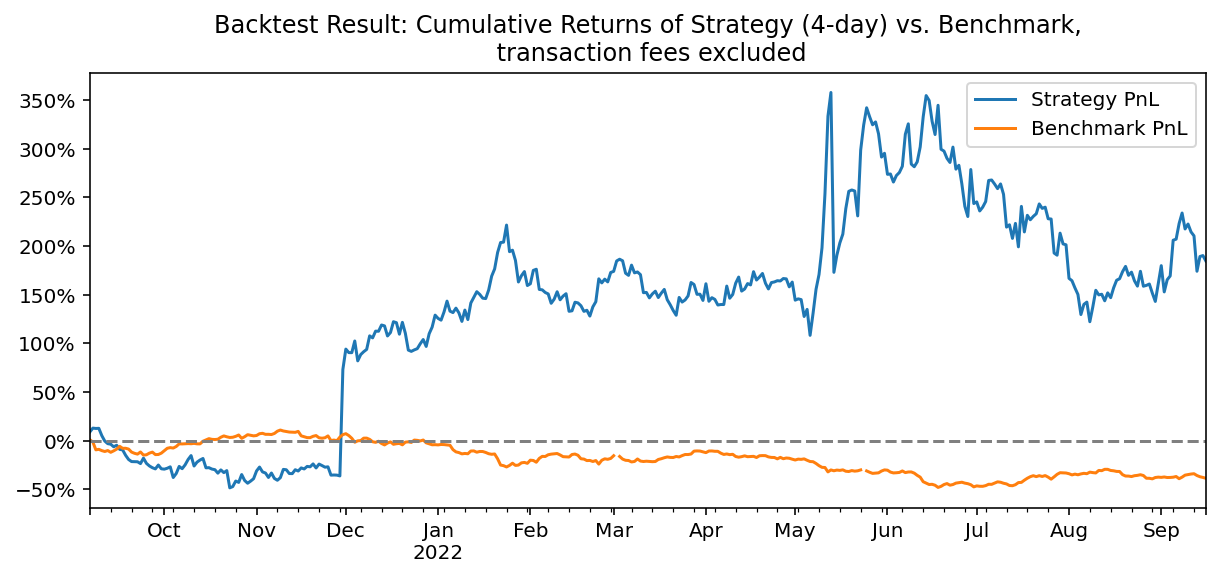

In [17]:
ax = bt_res_cumu_rets.plot()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.axhline(0, color='gray', linestyle = 'dashed')
ax.set(xlabel='', title='Backtest Result: Cumulative Returns of Strategy ({}-day) vs. Benchmark,\n transaction fees excluded'.format(ndays));
plt.savefig(os.path.join(png_dir, 'backtest_long_winners_short_losers_{}days.png'.format(ndays)), dpi=300);